#CNN - Ocular Disease Recognition

The task was: **Multiclass classification images**

Classification of Ocular disease images composed from different dataset:

*   https://www.kaggle.com/andrewmvd/retinal-disease-classification
*   https://www.kaggle.com/andrewmvd/ocular-disease-recognition-odir5k
*   https://ieee-dataport.org/open-access/retinal-fundus-multi-disease-image-dataset-rfmid

#### Dataset:

The dataset is a represent ‘‘real-life’’ set of patient and it is composed by 1805 images and there are grouped in 6 classes:

*   Normal: 900 images
*   Diabetes: 300 images
*   Age degeneration macular: 155 images
*   Cataract: 200 images
*   Glaucoma: 105 images
*   Pathological Myopia: 152 images

The dataset is not very large and this has created some difficulties with the training of the CNN network.

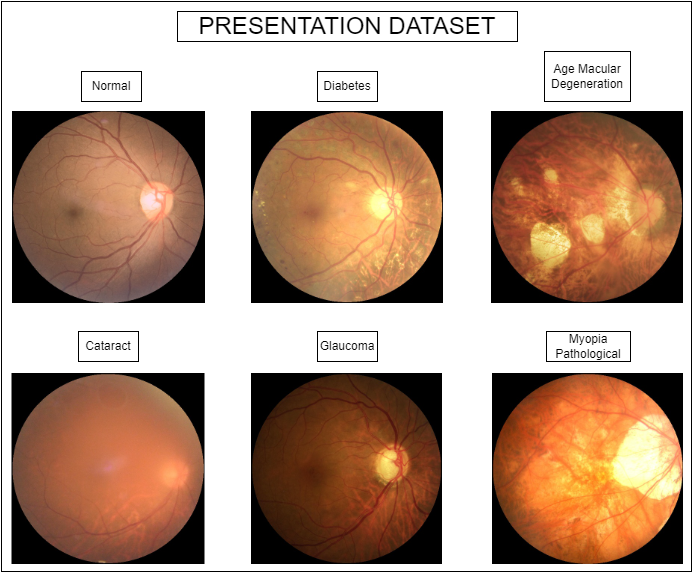


### Import module and library 

In [ ]:
!pip install gradio

     |████████████████████████████████| 659 kB 13.5 MB/s 
     |████████████████████████████████| 2.0 MB 60.3 MB/s 
     |████████████████████████████████| 84 kB 3.3 MB/s 
     |████████████████████████████████| 54 kB 3.6 MB/s 
     |████████████████████████████████| 255 kB 48.9 MB/s 
     |████████████████████████████████| 210 kB 71.6 MB/s 
     |████████████████████████████████| 1.1 MB 55.4 MB/s 
     |████████████████████████████████| 53 kB 2.8 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
     |████████████████████████████████| 144 kB 63.0 MB/s 
     |████████████████████████████████| 271 kB 53.2 MB/s 
     |████████████████████████████████| 58 kB 6.7 MB/s 
     |████████████████████████████████| 10.9 MB 41.5 MB/s 
     |████████████████████████████████| 79 kB 7.9 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 61 kB 575 kB/s 
     |████████████████████████████████| 856 kB 55.7 MB/s 
     |███████████████████████

In [ ]:
import gradio as gr
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
import time

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.applications import vgg16, vgg19
from keras.regularizers import l2
from tensorflow.keras.utils import normalize
from keras.preprocessing.image import ImageDataGenerator
from skimage import io
from sklearn.metrics import classification_report
import pathlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Definition of images path

In [ ]:
data_dir = ('/content/drive/MyDrive/ComputerVision - ODR/preprocessed_images')
data_dir = pathlib.Path(data_dir)

In [ ]:
#Check for understand if the images are correct
import os
import cv2
def check_images( s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                index=f.rfind('.')
                ext=f[index+1:].lower()
                if ext not in ext_list:
                    print('file ', f_path, ' has an invalid extension ', ext)  #first possibilities
                    bad_ext.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')   #second possibilities
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

source_dir = data_dir
good_exts=['jpg', 'png', 'jpeg', 'gif', 'bmp' ] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')
    for i in range (len(bad_file_list)):
        print (bad_file_list[i])
else:
    print(' no improper image files were found')

processing class directory  Glaucoma
processing class directory  Age_Macular_Degeneration
processing class directory  Myopia_Pathological
processing class directory  Diabetes
processing class directory  Normal
processing class directory  Cataract
 no improper image files were found


/content/drive/MyDrive/ComputerVision - ODR/preprocessed_images/Myopia_Pathological/106_right.jpg


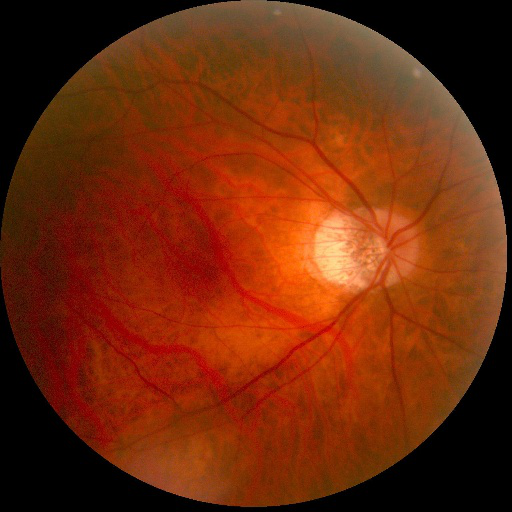

In [ ]:
#Print one images of the dataset
myo_eye = list(data_dir.glob('Myopia_Pathological/*'))
print(myo_eye[1])
PIL.Image.open(str(myo_eye[1]))

# Data Augmentation dataset

#### **How do I get more data, if I don’t have “more data”?**

The first option is known as offline augmentation. This method is preferred for relatively smaller datasets, as you would end up increasing the size of the dataset by a factor equal to the number of transformations you perform (For example, by flipping all my images, I would increase the size of my dataset by a factor of 2).

In this section, I decide to use ImageDataGenerator of keras to augment my initial dataset. At the beginning, I had a dataset of 1805 images, then I have a dataset of 8934 images.

The trasformations that I applied are:
- rotation
- flip
- rotation
- scale
- zoom
- traslation

In [ ]:
datagen = ImageDataGenerator(        
        rotation_range = 40,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        brightness_range = (0.5, 1.5))

In [ ]:
Glau_img = ('/content/drive/MyDrive/ComputerVision - ODR/preprocessed_images/Glaucoma/')
len(os.listdir('/content/drive/MyDrive/ComputerVision - ODR/preprocessed_images/Glaucoma/'))

1688

In [ ]:
Age_macular_img = ('/content/drive/MyDrive/ComputerVision - ODR/preprocessed_images/Age_Macular_Degeneration/')
len(os.listdir('/content/drive/MyDrive/ComputerVision - ODR/preprocessed_images/Age_Macular_Degeneration/'))

1762

In [ ]:
diab_macular_img = ('/content/drive/MyDrive/ComputerVision - ODR/preprocessed_images/Diabetes/')
len(os.listdir('/content/drive/MyDrive/ComputerVision - ODR/preprocessed_images/Diabetes/'))

1077

In [ ]:
myopia_img = ('/content/drive/MyDrive/ComputerVision - ODR/preprocessed_images/Myopia_Pathological/')
len(os.listdir('/content/drive/MyDrive/ComputerVision - ODR/preprocessed_images/Myopia_Pathological/'))

1699

In [ ]:
catar_img = ('/content/drive/MyDrive/ComputerVision - ODR/preprocessed_images/Cataract/')
len(os.listdir('/content/drive/MyDrive/ComputerVision - ODR/preprocessed_images/Cataract/'))

992

In [ ]:
norm_img = ('/content/drive/MyDrive/ComputerVision - ODR/preprocessed_images/Cataract/')
len(os.listdir('/content/drive/MyDrive/ComputerVision - ODR/preprocessed_images/Normal/'))

1716

In [ ]:
SIZE = 512
dataset = []
my_images0 = os.listdir(Age_macular_img)
for i, image_name in enumerate(my_images0):    
    if (image_name.split('.')[1] == 'jpg'):        
        image = io.imread(Age_macular_img + image_name)        
        image = Image.fromarray(image, 'RGB')        
        image = image.resize((SIZE,SIZE)) 
        dataset.append(np.array(image))
x = np.array(dataset)
i = 0
for batch in datagen.flow(x, batch_size=16,
                          save_to_dir='/content/drive/MyDrive/ComputerVision - ODR/preprocessed_images/Glaucoma',
                          save_prefix='dr',
                          save_format='jpg'):    
    i += 1    
    if i > 50:        
        break

In [ ]:
SIZE = 512
dataset = []
my_images1 = os.listdir(Glau_img)
for i, image_name in enumerate(my_images1):    
    if (image_name.split('.')[1] == 'jpg'):        
        image = io.imread(Glau_img + image_name)        
        image = Image.fromarray(image, 'RGB')        
        image = image.resize((SIZE,SIZE)) 
        dataset.append(np.array(image))
x = np.array(dataset)
i = 0
for batch in datagen.flow(x, batch_size=16,
                          save_to_dir='/content/drive/MyDrive/ComputerVision - ODR/preprocessed_images/Age_Macular_Degeneration/',
                          save_prefix='dr',
                          save_format='jpg'):    
    i += 1    
    if i > 50:        
        break

In [ ]:
SIZE = 512
dataset = []
my_images2 = os.listdir(diab_macular_img)
for i, image_name in enumerate(my_images2):    
    if (image_name.split('.')[1] == 'jpg'):        
        image = io.imread(diab_macular_img + image_name)        
        image = Image.fromarray(image, 'RGB')        
        image = image.resize((SIZE,SIZE)) 
        dataset.append(np.array(image))
x = np.array(dataset)
i = 0
for batch in datagen.flow(x, batch_size=16,
                          save_to_dir='/content/drive/MyDrive/ComputerVision - ODR/preprocessed_images/Diabetes/',
                          save_prefix='dr',
                          save_format='jpg'):    
    i += 1    
    if i > 50:        
        break

In [ ]:
SIZE = 512
dataset = []
my_images3 = os.listdir(myopia_img)
for i, image_name in enumerate(my_images3):    
    if (image_name.split('.')[1] == 'jpg'):        
        image = io.imread(myopia_img + image_name)        
        image = Image.fromarray(image, 'RGB')        
        image = image.resize((SIZE,SIZE)) 
        dataset.append(np.array(image))
x = np.array(dataset)
i = 0
for batch in datagen.flow(x, batch_size=16,
                          save_to_dir='/content/drive/MyDrive/ComputerVision - ODR/preprocessed_images/Myopia_Pathological/',
                          save_prefix='dr',
                          save_format='jpg'):    
    i += 1    
    if i > 50:        
        break

In [ ]:
SIZE = 512
dataset = []
my_images4 = os.listdir(catar_img)
for i, image_name in enumerate(my_images4):    
    if (image_name.split('.')[1] == 'jpg'):        
        image = io.imread(catar_img + image_name)        
        image = Image.fromarray(image, 'RGB')        
        image = image.resize((SIZE,SIZE)) 
        dataset.append(np.array(image))
x = np.array(dataset)
i = 0
for batch in datagen.flow(x, batch_size=16,
                          save_to_dir='/content/drive/MyDrive/ComputerVision - ODR/preprocessed_images/Cataract/',
                          save_prefix='dr',
                          save_format='jpg'):    
    i += 1    
    if i > 50:        
        break

In [ ]:
SIZE = 512
dataset = []
my_images5 = os.listdir(norm_img)
for i, image_name in enumerate(my_images5):    
    if (image_name.split('.')[1] == 'jpg'):        
        image = io.imread(norm_img + image_name)        
        image = Image.fromarray(image, 'RGB')        
        image = image.resize((SIZE,SIZE)) 
        dataset.append(np.array(image))
x = np.array(dataset)
i = 0
for batch in datagen.flow(x, batch_size=16,
                          save_to_dir='/content/drive/MyDrive/ComputerVision - ODR/preprocessed_images/Normal/',
                          save_prefix='dr',
                          save_format='jpg'):    
    i += 1    
    if i > 50:        
        break

# Hyperparameters fine-tuning and Model

#### **Calculate the weights of the classes**

The goal is to rebalance the dataset. For example, if I have a class with many observations then, I will assign less weight and vice versa.  

#### **how can i do it in keras?**

You can do this by passing the Keras weights for each class through a parameter. This will cause the model to "pay more attention" to examples of an underrepresented class.

Formula:  WEIGHTS_CLASS = (1/number of class image)*(tot images)/(number label)

In [ ]:
weights_age_mac_0 = (1 / 1762)*(8041)/6
weights_age_mac_1 = (1 / 992)*(8041)/6
weights_age_mac_2 = (1 / 1077)*(8041)/6
weights_age_mac_3 = (1 / 1688)*(8041)/6
weights_age_mac_4 = (1 / 1699)*(8041)/6
weights_age_mac_5 = (1 / 1716)*(8041)/6

In [ ]:
class_weight = {0: weights_age_mac_0,
                1: weights_age_mac_1,
                2: weights_age_mac_2,
                3: weights_age_mac_3,
                4: weights_age_mac_4,
                5: weights_age_mac_5}
class_weight

{0: 0.7605940219447597,
 1: 1.3509744623655913,
 2: 1.2443515939337666,
 3: 0.7939375987361771,
 4: 0.7887973317637825,
 5: 0.780982905982906}

In [ ]:
#Choice of the hyperparameters
Batch_size = 8
Img_height=512
Img_width=512

In [ ]:
#Choice of different data
train_ds = image_dataset_from_directory(
    directory='/content/drive/MyDrive/ComputerVision - ODR/preprocessed_images',
    validation_split=0.10,
    seed=123,
    subset="training",
    batch_size=Batch_size,
    image_size=(Img_height,Img_width))
validation_ds = image_dataset_from_directory(
    directory='/content/drive/MyDrive/ComputerVision - ODR/preprocessed_images',
    validation_split=0.10,
    seed=123,
    subset="validation",
    batch_size=Batch_size,
    image_size=(Img_height,Img_width))

Found 8934 files belonging to 6 classes.
Using 8041 files for training.
Found 8934 files belonging to 6 classes.
Using 893 files for validation.


In [ ]:
#Number of classes
class_names = train_ds.class_names
print(class_names)

['Age_Macular_Degeneration', 'Cataract', 'Diabetes', 'Glaucoma', 'Myopia_Pathological', 'Normal']


# **TRANSFER LEARNING - "VGG16 model"**

## Examples of classification with one of the best CNN architecture.

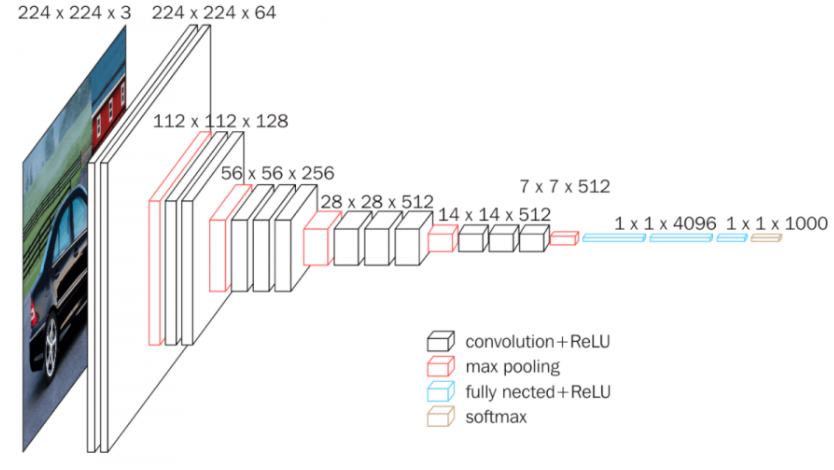

In [ ]:
base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(512, 512, 3), # VGG16 expects min 32 x 32
    include_top=False)  # Do not include the ImageNet classifier at the top.
base_model.trainable = False

### **Add some layers to the Vgg16 architecture**

In [ ]:
number_of_classes = 6
inputs = keras.Input(shape=(512, 512, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
initializer = tf.keras.initializers.GlorotUniform(seed=42)
activation =  tf.keras.activations.sigmoid
outputs = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer,
                             activation=activation)(x) 
model1 = keras.Model(inputs, outputs)

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, 128, 128)     0     

In [ ]:
model1.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 512, 512, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 16, 16, 512)       14714688  
                                                                 
 global_average_pooling2d_13  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_24 (Dense)            (None, 6)                 3078      
                                                                 
Total params: 14,717,766
Trainable params: 3,078
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model1.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

## **Training phase**

In [ ]:
Epochs=20
history = model1.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=Epochs,
  class_weight=class_weight
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1006/1006 [==============================] - 301s 295ms/step - loss: 0.9522 - sparse_categorical_accuracy: 0.5687 - val_loss: 0.8564 - val_sparse_categorical_accuracy: 0.6618
Epoch 2/20
1006/1006 [==============================] - 300s 297ms/step - loss: 0.6790 - sparse_categorical_accuracy: 0.6984 - val_loss: 0.7255 - val_sparse_categorical_accuracy: 0.7111
Epoch 3/20
1006/1006 [==============================] - 302s 300ms/step - loss: 0.6014 - sparse_categorical_accuracy: 0.7306 - val_loss: 0.7164 - val_sparse_categorical_accuracy: 0.7055
Epoch 4/20
1006/1006 [==============================] - 300s 298ms/step - loss: 0.5502 - sparse_categorical_accuracy: 0.7524 - val_loss: 0.6548 - val_sparse_categorical_accuracy: 0.7290
Epoch 5/20
1006/1006 [==============================] - 300s 298ms/step - loss: 0.5257 - sparse_categorical_accuracy: 0.7633 - val_loss: 0.6471 - val_sparse_categorical_accuracy: 0.7335
Epoch 6/20
1006/1006 [==============================] - 302s 300ms/step - loss: 0

### **Visualization of metrics: Accuracy and Loss**

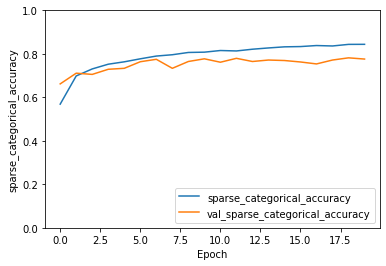

In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'], label='sparse_categorical_accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'val_sparse_categorical_accuracy')
plt.xlabel('Epoch')
plt.ylabel('sparse_categorical_accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')
plt.show()

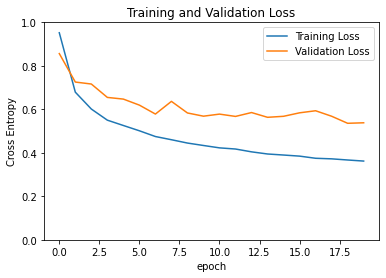

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
y_pred = model1.predict(validation_ds, batch_size=1)

predicted_categories = np.argmax(y_pred, axis=1)
len(predicted_categories)


893

In [ ]:
y_pred[:1]

array([[6.2353706e-01, 1.6852149e-05, 2.8462965e-02, 5.5393940e-01,
        8.6157676e-03, 4.7056223e-03]], dtype=float32)

In [ ]:
predicted_categories

array([0, 3, 5, 3, 5, 0, 4, 0, 5, 4, 3, 2, 1, 2, 5, 1, 4, 1, 3, 5, 0, 0,
       2, 3, 2, 3, 2, 0, 5, 3, 4, 5, 2, 5, 3, 2, 0, 3, 2, 1, 4, 5, 2, 4,
       5, 5, 0, 5, 3, 4, 1, 1, 5, 0, 4, 2, 5, 3, 3, 1, 1, 4, 3, 4, 0, 3,
       0, 0, 0, 4, 4, 3, 5, 5, 4, 4, 5, 2, 0, 3, 0, 2, 5, 3, 2, 5, 4, 5,
       4, 4, 3, 2, 5, 1, 4, 0, 4, 5, 0, 3, 3, 3, 1, 2, 0, 2, 4, 4, 4, 1,
       2, 2, 4, 5, 4, 2, 1, 2, 5, 5, 4, 3, 3, 3, 4, 3, 4, 0, 5, 2, 3, 2,
       5, 5, 1, 3, 3, 1, 0, 2, 5, 5, 0, 2, 3, 3, 0, 0, 0, 4, 5, 5, 5, 0,
       5, 4, 1, 5, 1, 3, 5, 3, 0, 4, 3, 3, 1, 1, 2, 5, 0, 3, 1, 3, 0, 4,
       2, 4, 5, 3, 0, 4, 5, 5, 3, 0, 0, 5, 1, 2, 4, 1, 3, 5, 1, 5, 3, 3,
       4, 3, 1, 2, 1, 0, 4, 1, 4, 4, 5, 5, 1, 5, 1, 2, 3, 3, 5, 3, 5, 3,
       1, 5, 3, 1, 5, 1, 4, 3, 3, 2, 1, 2, 2, 4, 5, 3, 0, 5, 2, 1, 3, 0,
       4, 2, 2, 1, 5, 4, 5, 2, 1, 3, 2, 4, 2, 3, 2, 2, 4, 2, 4, 2, 0, 3,
       0, 1, 3, 4, 1, 5, 5, 0, 4, 0, 5, 4, 3, 4, 2, 0, 3, 2, 2, 1, 0, 3,
       2, 0, 0, 4, 4, 1, 4, 3, 4, 5, 0, 1, 4, 3, 5,

In [ ]:
true_categories = tf.concat([y for x, y in validation_ds], axis=0).numpy()
true_categories_argmax = np.argmax(true_categories)

In [ ]:
true_categories

array([3, 3, 4, 1, 1, 4, 3, 5, 3, 4, 1, 4, 0, 1, 4, 4, 2, 2, 2, 0, 5, 2,
       4, 1, 5, 4, 2, 5, 3, 0, 0, 3, 4, 1, 3, 5, 2, 2, 2, 4, 5, 4, 5, 0,
       2, 0, 5, 0, 3, 3, 1, 1, 2, 3, 1, 3, 1, 5, 5, 4, 3, 2, 2, 2, 0, 5,
       1, 0, 3, 3, 4, 2, 1, 3, 3, 1, 4, 3, 2, 0, 4, 0, 4, 3, 2, 5, 2, 4,
       1, 3, 2, 5, 5, 0, 4, 1, 0, 4, 5, 3, 3, 1, 1, 5, 3, 5, 4, 0, 1, 4,
       1, 1, 5, 1, 5, 1, 4, 3, 0, 0, 2, 1, 1, 5, 4, 1, 5, 2, 0, 1, 5, 1,
       0, 4, 3, 1, 1, 5, 2, 1, 5, 5, 2, 2, 2, 5, 0, 4, 5, 2, 2, 5, 2, 0,
       4, 3, 2, 5, 4, 2, 0, 2, 0, 4, 5, 3, 3, 1, 0, 1, 4, 3, 2, 2, 5, 5,
       3, 5, 1, 3, 0, 5, 1, 5, 0, 0, 5, 4, 1, 5, 1, 2, 0, 3, 1, 0, 3, 3,
       1, 4, 3, 1, 0, 1, 1, 3, 5, 5, 1, 3, 5, 4, 2, 5, 0, 5, 4, 2, 3, 2,
       4, 2, 3, 0, 0, 1, 4, 3, 1, 3, 1, 4, 0, 0, 3, 5, 2, 1, 0, 4, 4, 0,
       0, 4, 5, 4, 2, 4, 4, 2, 3, 3, 1, 0, 1, 5, 0, 0, 3, 1, 0, 5, 0, 3,
       1, 5, 5, 3, 3, 3, 3, 4, 4, 1, 4, 5, 3, 0, 5, 4, 4, 4, 2, 3, 0, 0,
       2, 5, 1, 4, 0, 0, 4, 4, 0, 0, 0, 5, 4, 3, 5,